# Comprehensive Job Description Analysis & Standardization Strategy

## Objectives
This notebook performs a deep-dive analysis on the job description dataset (`Hackathon_Datasets_Refined_v5.csv`) to drive the standardization process. It goes beyond basic clustering to provide actionable insights for HR and organizational efficiency.

**Key Analyses:**
1.  **Hierarchical Clustering:** Uncovering the natural taxonomy of roles (Dendrograms).
2.  **Standardization Scout:** Identifying "Near-Duplicate" roles (high content similarity, different titles).
3.  **Cluster Profiling:** Analyzing job levels and distinctive terminology (N-grams) within families.
4.  **"Messiness" Report:** Ranking job families by variance to prioritize standardization efforts.

In [1]:
# Install necessary libraries
!pip install sentence-transformers pandas numpy scikit-learn seaborn matplotlib scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Configuration
INPUT_FILE = 'Hackathon_Datasets_Refined_v5.csv'
MODEL_NAME = 'all-MiniLM-L6-v2'
RANDOM_STATE = 42

# Output Settings
pd.set_option('display.max_colwidth', None)
plt.style.use('seaborn-v0_8-whitegrid')

/Users/rohanjasani/.pyenv/versions/3.12.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading & Preprocessing
We construct a rich text representation for each job by combining title, summary, responsibilities, and qualifications.

In [3]:
# Load Data
print(f"Loading {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Preprocessing: Fill NaN values
text_cols = ['Unified Job Title', 'position_summary', 'responsibilities', 'qualifications']
for col in text_cols:
    df[col] = df[col].fillna('')

# Weighting the Title: We repeat it to ensure the model pays attention to the explicit label
df['combined_text'] = (
    "Job Title: " + df['Unified Job Title'] + ". " +
    "Job Title: " + df['Unified Job Title'] + ". " +  # Repeated for emphasis
    "Summary: " + df['position_summary'] + ". " +
    "Responsibilities: " + df['responsibilities'] + ". " +
    "Qualifications: " + df['qualifications']
)

print(f"Loaded {len(df)} job records.")

Loading Hackathon_Datasets_Refined_v5.csv...
Loaded 622 job records.


## 2. Generating High-Dimensional Embeddings
Using **SBERT (Sentence-BERT)** to transform job descriptions into dense vector representations that capture semantic meaning.

In [4]:
print(f"Loading SBERT Model ({MODEL_NAME})...")
model = SentenceTransformer(MODEL_NAME)

print("Generating embeddings...")
embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True)
print(f"Embeddings Matrix Shape: {embeddings.shape}")

Loading SBERT Model (all-MiniLM-L6-v2)...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2129.24it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings...


Batches: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

Embeddings Matrix Shape: (622, 384)


## 3. Phase 1: High-Resolution Hierarchical Clustering
Investigating the natural taxonomy of the organization using Ward's method. This visualization helps us see how major departments break down into sub-families.

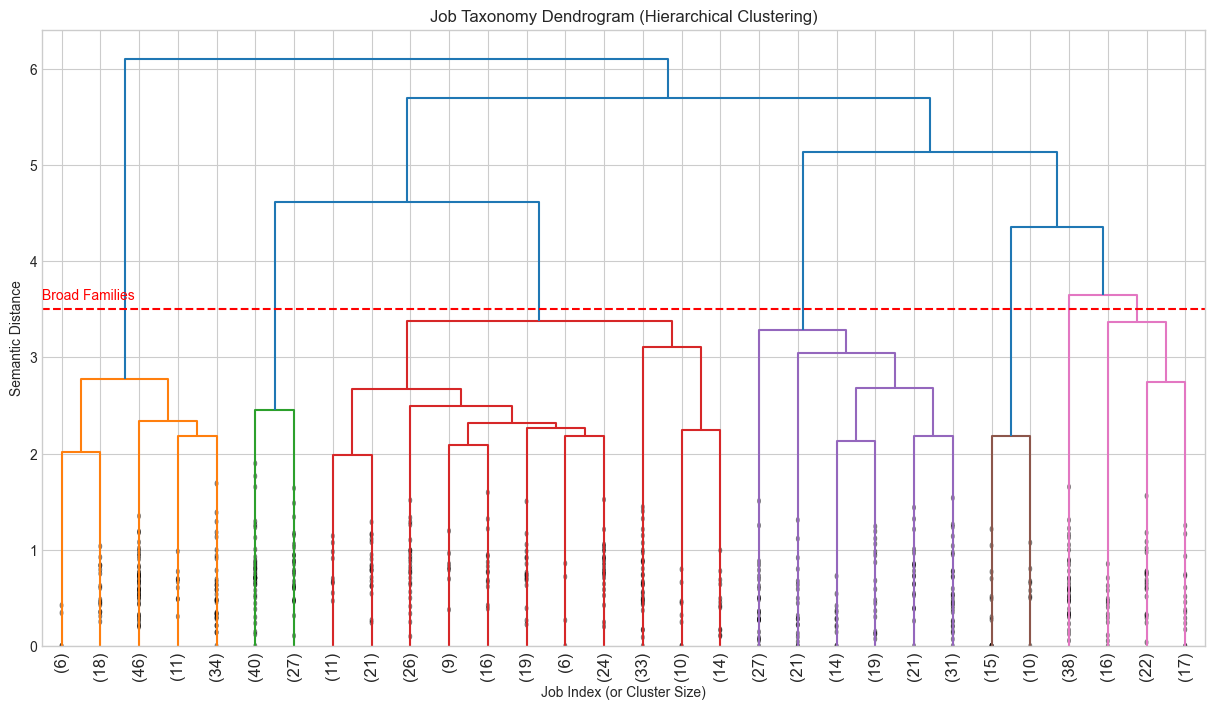

In [5]:
# Compute Linkage Matrix (Ward's Method minimizes variance within clusters)
linked = linkage(embeddings, 'ward')

# Plot Dendrogram (Truncated for readability)
plt.figure(figsize=(15, 8))
plt.title('Job Taxonomy Dendrogram (Hierarchical Clustering)')
plt.xlabel('Job Index (or Cluster Size)')
plt.ylabel('Semantic Distance')
dendrogram(
    linked,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,                   # show only the last 30 merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.axhline(y=3.5, color='r', linestyle='--', label='Potential Cut Line (High Level)')
plt.text(0, 3.6, 'Broad Families', color='r')
plt.show()

## 4. Phase 2: Refined Clustering (K-Means)
Based on the previous analysis (which suggested ~12 clusters), we will enforce a practical number of clusters (e.g., 15) to get granular families and assign every job to a family.

In [6]:
NUM_CLUSTERS = 15

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
df['Cluster_ID'] = kmeans.fit_predict(embeddings)

# Calculate Distance to Cluster Center for each point (Messiness Metric)
centers = kmeans.cluster_centers_
distances = []
for i, row in df.iterrows():
    cluster_idx = row['Cluster_ID']
    center = centers[cluster_idx]
    dist = np.linalg.norm(embeddings[i] - center)
    distances.append(dist)
df['Distance_to_Center'] = distances

print("Cluster Assignments Completed.")

Cluster Assignments Completed.


## 5. Phase 3: Cluster Profiling & N-Gram Analysis
Extracting distinctive keywords (Bi-grams) for each cluster to automatically label them (e.g., "Supply Chain", "Process Engineering").

In [7]:
def get_top_ngrams(corpus, n=2, top_k=5):
    """Extract frequent n-grams from a text corpus excluding stop words."""
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english', min_df=2).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return [w[0] for w in words_freq[:top_k]]

cluster_profiles = []

print("Profiling Candidates...")
for cid in range(NUM_CLUSTERS):
    cluster_df = df[df['Cluster_ID'] == cid]
    
    # Representative text for N-gram extraction
    # We focus on Title + Summary for cleaner keywords
    text_corpus = (cluster_df['Unified Job Title'] + " " + cluster_df['position_summary']).tolist()
    
    # Catch empty or too small clusters
    if len(text_corpus) < 2:
        continue
        
    top_bigrams = get_top_ngrams(text_corpus, n=2, top_k=4)
    sample_titles = cluster_df['Unified Job Title'].value_counts().head(3).index.tolist()
    
    # Calculate "Tightness" (Lower Std Dev of Distance means more consistent)
    tightness = cluster_df['Distance_to_Center'].mean()
    
    cluster_profiles.append({
        'Cluster ID': cid,
        'Size': len(cluster_df),
        'Avg Distance (Messiness)': round(tightness, 3),
        'Distinctive Terms': ", ".join(top_bigrams),
        'Common Titles': ", ".join(sample_titles)
    })

profile_df = pd.DataFrame(cluster_profiles)
display(profile_df.sort_values('Avg Distance (Messiness)', ascending=False)) # Most chaotic clusters first

Profiling Candidates...


,Cluster ID,Size,Avg Distance (Messiness),Distinctive Terms,Common Titles
0,0,77,0.695,"opportunity position, talented team, team powerful, powerful impact","Ie Engineer, Loss Prevention Engineer, Production Shift Supervisor"
3,3,37,0.667,"supply chain, customer service, marketing logistics, talented team","Manager, M&L Business Systems, Product Handler (Temp), Commercial Director -"
13,13,42,0.630,"executive office, business services, administrative support, administrative assistant","Executive Office Coordinator, Corporate Office Receptionist, Administrative Assistant Responsible Care"
8,8,26,0.625,"medicine hat, methanex medicine, stakeholder relations, responsible care","Finance Manager, Technical Manager, IT Business Relationship Lead Pd (Mh)"
4,4,47,0.611,"supply chain, global supply, director global, global gas","Global Tactical Planner, Manager, Global Supply Chain Planning, 05_Internal - Market Analyst"
10,10,41,0.598,"corporate finance, corporate development, risk management, regional finance","Corporate Counsel, Manager, Treasury And Corporate Finance, VP Corporate Finance"
9,9,57,0.579,"corporate reporting, financial reporting, manager corporate, reporting analyst","Financial Reporting Analyst, Senior Reporting Analyst, Treasury Analyst"
12,12,91,0.574,"service desk, global team, external contacts, service providers","Applications Analyst, Service Desk Analyst, Global IT Service Desk Lead"
11,11,31,0.566,"systems analyst, business systems, business process, functional analyst","Senior Network Security Analyst, Business Systems Analyst, Pd - Senior Functional Analyst"
1,1,37,0.562,"global communications, investor relations, corporate sustainability, stakeholder relations","Sustainability And Communications Coordinator, Communications Specialist, Director, Corporate Sustainability"


## 6. Phase 4: Standardization Scout (The "Mirror" Detector)
This is the most critical step for standardization. We look for jobs that are **semantically identical (>95% similarity)** but have **different titles**.
These are immediate candidates for title consolidation.

In [8]:
# Calculate Cosine Similarity Matrix (600x600 is fast)
sim_matrix = cosine_similarity(embeddings)

potential_duplicates = []
threshold = 0.95  # Strict threshold for "near-identical" roles

# Iterate through upper triangle of matrix
visited = set()
rows, cols = sim_matrix.shape

for i in range(rows):
    for j in range(i + 1, cols):
        score = sim_matrix[i, j]
        if score > threshold:
            title_a = df.iloc[i]['Unified Job Title']
            title_b = df.iloc[j]['Unified Job Title']
            
            # Only flag if titles are DIFFERENT (ignore exact matches, they are boring)
            # Also check if title_a contains title_b to avoid "Senior Acct" vs "Acct" trivial matches if desired
            # But here we want to catch ALL inconsistencies.
            if title_a.lower() != title_b.lower():
                potential_duplicates.append({
                    'Job A': title_a,
                    'Job B': title_b,
                    'Similarity Score': round(score, 4),
                    'Cluster': df.iloc[i]['Cluster_ID']
                })

dup_df = pd.DataFrame(potential_duplicates)
if not dup_df.empty:
    print(f"Found {len(dup_df)} pairs of Near-Duplicate roles with different titles.")
    display(dup_df.sort_values('Similarity Score', ascending=False).head(20))
else:
    print("No near-duplicates found above threshold.")

Found 71 pairs of Near-Duplicate roles with different titles.


,Job A,Job B,Similarity Score,Cluster
29,"Manager, Global Taxation","Manager, Global Taxation1",0.9981,7
31,"Manager, Global Taxation","Manager, Global Taxation1",0.9981,7
32,"Manager, Global Taxation1","Manager, Global Taxation",0.9970,7
5,Global Tactical Planner -,Global Tactical Planner,0.9970,4
6,Global Tactical Planner -,Global Tactical Planner,0.9970,4
11,"Manager, Global Communications (10)","Manager, Global Communications (09)",0.9948,1
9,Mechanical Project Execution Coordinator -,Mechanical Project Execution Coordinator,0.9944,0
26,"Senior Auditor, People Leader",Senior Auditor (Supervisor),0.9939,6
66,General Counsel Corporate Secretary With Communications,General Counsel & Corporate Secretary,0.9938,1
7,Senior Accounting And Management Supervisor - Chile,Senior Accounting And Management Supervisor,0.9924,9


## 7. Conclusions & Action Plan

### **Highest Priority for Standardization (The "Messy" Clusters)**
Look at the Cluster Profile table above. Clusters with **Higher Avg Distance** contain roles that are loosely defined or contain a mix of disparate skills. These departments need interviews to clarify role boundaries.

### **Immediate Wins (The "Mirror" Roles)**
The *Near-Duplicate* table identifies roles that perform the exact same function but have inconsistent titles. 
**Action:** Recommend consolidating these title pairs immediately (e.g., rename all "Sr. Acct Specialist" to "Senior Accountant").